<a href="https://colab.research.google.com/github/OmdenaAI/SudanChapter_AnalyzeHealthcareAccessibility/blob/main/05_Modelling/Healthcare_Accessibility_Predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for Healthcare Accessibility in Sudan

### Loading packages and Datasets

In [ ]:
# Loading Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy.distance import geodesic


In [ ]:
# Loading Git Repository

!git clone https://github.com/OmdenaAI/SudanChapter_AnalyzeHealthcareAccessibility.git


Cloning into 'SudanChapter_AnalyzeHealthcareAccessibility'...
remote: Enumerating objects: 1363, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 1363 (delta 94), reused 34 (delta 29), pack-reused 1224 (from 1)
Receiving objects: 100% (1363/1363), 401.70 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (731/731), done.
Updating files: 100% (167/167), done.


In [ ]:
# Loading Healthcare Data

hc_facilities = pd.read_csv('/content/SudanChapter_AnalyzeHealthcareAccessibility/04_Data_analysis/final_data_folder/final_healthcare_facility_dataset.csv')
hc_facilities = hc_facilities.drop(['Unnamed: 0', 'addr_city', 'osm_id', 'osm_type'], axis= 1)
hc_facilities.head()

,name,amenity,geometry,name_english,Latitude,Longitude,City,State
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),Orchid Pharmacy,15.450937,32.491688,Khartoum,Khartoum
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),Abu Al-Muqdad Pharmacy 9,15.443063,32.489563,Khartoum,Khartoum
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),Awab Pharmacy,15.440437,32.490311,Khartoum,Khartoum
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),Green Apple Pharmacy,15.598433,32.618954,Khartoum,Khartoum
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),Africa pharmcy,15.533049,32.569464,Khartoum,Khartoum


In [ ]:
# Loading Population Data

population_data = pd.read_csv('/content/SudanChapter_AnalyzeHealthcareAccessibility/04_Data_analysis/final_data_folder/population-by-cities-data.csv')

population_data.head()

,city,country,pop2024,latitude,longitude
0,Khartoum,Sudan,1974647,15.5518,32.5324
1,Omdurman,Sudan,1200000,15.6445,32.4777
2,Nyala,Sudan,565734,12.0489,24.8807
3,Port Sudan,Sudan,489725,19.6175,37.2164
4,Kassala,Sudan,401477,15.4510,36.4000


### Understanding the Data

In [ ]:
hc_facilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1092 non-null   object 
 1   amenity       1109 non-null   object 
 2   geometry      1129 non-null   object 
 3   name_english  1092 non-null   object 
 4   Latitude      1129 non-null   float64
 5   Longitude     1129 non-null   float64
 6   City          1129 non-null   object 
 7   State         1129 non-null   object 
dtypes: float64(2), object(6)
memory usage: 70.7+ KB


In [ ]:
hc_facilities.isnull().sum()

,0
name,37
amenity,20
geometry,0
name_english,37
Latitude,0
Longitude,0
City,0
State,0


In [ ]:
hc_facilities['amenity'].value_counts()

,count
amenity,
pharmacy,845
clinic,120
hospital,99
dentist,27
doctors,18


In [ ]:
hc_facilities.nunique()

,0
name,1029
amenity,5
geometry,1125
name_english,1015
Latitude,1092
Longitude,1069
City,27
State,15


In [ ]:
hc_facilities['geometry'][0]

'POINT (32.4916878 15.4509373)'

In [ ]:
population_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       71 non-null     object 
 1   country    71 non-null     object 
 2   pop2024    71 non-null     int64  
 3   latitude   71 non-null     float64
 4   longitude  71 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.9+ KB


In [ ]:
population_data.isnull().sum()

,0
city,0
country,0
pop2024,0
latitude,0
longitude,0


In [ ]:
population_data.nunique()

,0
city,71
country,1
pop2024,71
latitude,69
longitude,71


In [ ]:
missing_cities = set(population_data['city'].unique()) - set(hc_facilities['City'].unique())
print(missing_cities)

{'Kadugli', 'Sawakin', 'El Fasher', 'Kosti', 'Ad Dindar', 'Berber', 'Ar Ruseris', 'Um Jar Al Gharbiyya', 'Maiurno', 'El Fula', 'Dilling', 'Singa', 'Abu Jibeha', 'El Obeid', 'Kutum', 'Al Lagowa', 'El Matama', 'Al Fulah', 'Rabak', 'Kinana', 'Abu Zabad', 'Wagar', 'Al Qadarif', 'Talodi', 'Doka', 'Umm Kaddadah', 'Al Kiremit al `Arakiyyin', 'Jalqani', 'Wad az Zaki', 'Umm Ruwaba', 'Shendi', 'Al Masallamiyya', 'Ad-Damazin', 'As Suki', 'Al Qitena', 'Kurmuk', 'El Bauga', 'Gebeit', 'Tokar', 'Gereida', 'Ad Douiem', 'Tandalti', 'Aroma', 'Ed Damer'}


### Preparation for Data Modeling

In [ ]:
# Merging datasets by cities in both data frames and dropping unnecessary columns

merged = pd.merge(hc_facilities, population_data, left_on='City', right_on='city', how='inner').drop(['City', 'name_english', 'country'], axis= 1)
merged.head()

,name,amenity,geometry,Latitude,Longitude,State,city,pop2024,latitude,longitude
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,1974647,15.5518,32.5324
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,1974647,15.5518,32.5324
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),15.440437,32.490311,Khartoum,Khartoum,1974647,15.5518,32.5324
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),15.598433,32.618954,Khartoum,Khartoum,1974647,15.5518,32.5324
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),15.533049,32.569464,Khartoum,Khartoum,1974647,15.5518,32.5324


In [ ]:
# Checking for null values

merged.isnull().sum()

,0
name,37
amenity,20
geometry,0
Latitude,0
Longitude,0
State,0
city,0
pop2024,0
latitude,0
longitude,0


In [ ]:
merged.shape

(1129, 10)

In [ ]:
# Renaming columns for ease of use

merged = merged.rename(columns= {'Latitude': 'fac_lat', 'Longitude': 'fac_long', 'State': 'state', 'latitude': 'city_lat', 'longitude': 'city_long'})
merged_copy = merged.copy()
merged_copy.head(2)

,name,amenity,geometry,fac_lat,fac_long,state,city,pop2024,city_lat,city_long
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,1974647,15.5518,32.5324
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,1974647,15.5518,32.5324


In [ ]:
# Calculating accessibility for each city

# Function to calculate distance and accessible facilities
def distance_calculator(df):
    distance = df.apply(lambda row: geodesic((row['city_lat'], row['city_long']), (row['fac_lat'], row['fac_long'])).km, axis=1)
    return distance

# Add a new feature called distance
merged_copy['distance'] = distance_calculator(merged_copy)

# Add a new feature for accessible facilities in population data
merged_copy['accessible_facilities'] = merged_copy['distance'].apply(lambda x: 1 if x <= 5 else 0)

# # Add a facilities-per-capita feature for analysis
# merged_copy['facilities_per_capita'] = merged_copy['accessible_facilities'] / merged_copy['pop2024']


In [ ]:
merged_copy.head(5)

,name,amenity,geometry,fac_lat,fac_long,state,city,pop2024,city_lat,city_long,distance,accessible_facilities
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,1974647,15.5518,32.5324,11.985223,0
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,1974647,15.5518,32.5324,12.880180,0
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),15.440437,32.490311,Khartoum,Khartoum,1974647,15.5518,32.5324,13.124169,0
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),15.598433,32.618954,Khartoum,Khartoum,1974647,15.5518,32.5324,10.621262,0
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),15.533049,32.569464,Khartoum,Khartoum,1974647,15.5518,32.5324,4.484830,1


In [ ]:
merged_copy['accessible_facilities'].value_counts()

,count
accessible_facilities,
0,697
1,432


In [ ]:
merged_copy.isna().sum()

,0
name,37
amenity,20
geometry,0
fac_lat,0
fac_long,0
state,0
city,0
pop2024,0
city_lat,0
city_long,0


In [ ]:
# One-Hot Encoding of the 'amenity' column
from sklearn.preprocessing import OneHotEncoder

encoder_ext = OneHotEncoder(sparse_output=False)
amenity_encoded = encoder_ext.fit_transform(merged_copy[["amenity"]])
amenity_columns = encoder_ext.get_feature_names_out(["amenity"])

print(amenity_columns)

['amenity_clinic' 'amenity_dentist' 'amenity_doctors' 'amenity_hospital'
 'amenity_pharmacy' 'amenity_nan']


In [ ]:
# Merge encoded amenities into the dataset
df_amenities = pd.DataFrame(amenity_encoded, columns=amenity_columns)
merged_copy = pd.concat([merged_copy, df_amenities], axis=1)

merged_copy.head()

,name,amenity,geometry,fac_lat,fac_long,state,city,pop2024,city_lat,city_long,distance,accessible_facilities,amenity_clinic,amenity_dentist,amenity_doctors,amenity_hospital,amenity_pharmacy,amenity_nan
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,1974647,15.5518,32.5324,11.985223,0,0.0,0.0,0.0,0.0,1.0,0.0
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,1974647,15.5518,32.5324,12.880180,0,0.0,0.0,0.0,0.0,1.0,0.0
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),15.440437,32.490311,Khartoum,Khartoum,1974647,15.5518,32.5324,13.124169,0,0.0,0.0,0.0,0.0,1.0,0.0
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),15.598433,32.618954,Khartoum,Khartoum,1974647,15.5518,32.5324,10.621262,0,0.0,0.0,0.0,0.0,1.0,0.0
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),15.533049,32.569464,Khartoum,Khartoum,1974647,15.5518,32.5324,4.484830,1,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Compute density feature for each amenity type within in a 1 km radius

from scipy.spatial import KDTree

coords = np.radians(merged_copy[["fac_lat", "fac_long"]])  # Convert to radians
tree_ext = KDTree(coords)

In [ ]:
# Function to count facilities of a given type within 1 km radius

def count_nearby_facilities(index, amenity_col, radius_km=1):
    lat, lon = coords.iloc[index]
    neighbors = tree_ext.query_ball_point([lat, lon], r=radius_km / 6371)  # Convert km to radians
    return sum(merged_copy.iloc[neighbors][amenity_col]) - merged_copy.at[index, amenity_col]  # Exclude itself

In [ ]:
# Calculate density for each amenity type
for amenity_col in amenity_columns:
    merged_copy[f"{amenity_col}_density_1km"] = [count_nearby_facilities(i, amenity_col) for i in range(len(merged_copy))]

merged_copy.head()

,name,amenity,geometry,fac_lat,fac_long,state,city,pop2024,city_lat,city_long,...,amenity_doctors,amenity_hospital,amenity_pharmacy,amenity_nan,amenity_clinic_density_1km,amenity_dentist_density_1km,amenity_doctors_density_1km,amenity_hospital_density_1km,amenity_pharmacy_density_1km,amenity_nan_density_1km
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,1974647,15.5518,32.5324,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,1974647,15.5518,32.5324,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),15.440437,32.490311,Khartoum,Khartoum,1974647,15.5518,32.5324,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),15.598433,32.618954,Khartoum,Khartoum,1974647,15.5518,32.5324,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,19.0,0.0
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),15.533049,32.569464,Khartoum,Khartoum,1974647,15.5518,32.5324,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
merged_copy.columns

Index(['name', 'amenity', 'geometry', 'fac_lat', 'fac_long', 'state', 'city',
       'pop2024', 'city_lat', 'city_long', 'distance', 'accessible_facilities',
       'amenity_clinic', 'amenity_dentist', 'amenity_doctors',
       'amenity_hospital', 'amenity_pharmacy', 'amenity_nan',
       'amenity_clinic_density_1km', 'amenity_dentist_density_1km',
       'amenity_doctors_density_1km', 'amenity_hospital_density_1km',
       'amenity_pharmacy_density_1km', 'amenity_nan_density_1km'],
      dtype='object')

In [ ]:
merged_copy['accessible_facilities'].head(4)

,accessible_facilities
0,0
1,0
2,0
3,0


In [ ]:
# Compute new facilities_per_capita feature

merged_copy["facilities_per_capita"] = (
    merged_copy[
        [
            "amenity_clinic_density_1km",
            "amenity_dentist_density_1km",
            "amenity_doctors_density_1km",
            "amenity_hospital_density_1km",
            "amenity_pharmacy_density_1km",
        ]
    ].sum(axis=1) / merged_copy["pop2024"]
)

merged_copy['facilities_per_capita'].head(4)

,facilities_per_capita
0,0.000005
1,0.000004
2,0.000003
3,0.000010


### Preprocessing Procedure

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define feature columns for scaling
features_to_scale = [
    "pop2024",
    "facilities_per_capita",
    "distance",
    "amenity_clinic_density_1km",
    "amenity_dentist_density_1km",
    "amenity_doctors_density_1km",
    "amenity_hospital_density_1km",
    "amenity_pharmacy_density_1km",
]

# Standardize numerical features
scaler = StandardScaler()
merged_copy[features_to_scale] = scaler.fit_transform(merged_copy[features_to_scale])

# Define features (X) and target (y)
X = merged_copy[features_to_scale]  # Use scaled features
y = merged_copy["accessible_facilities"]  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Supervised Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9336283185840708
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       134
           1       0.96      0.87      0.91        92

    accuracy                           0.93       226
   macro avg       0.94      0.92      0.93       226
weighted avg       0.94      0.93      0.93       226



In [ ]:
merged_copy.head()

,name,amenity,geometry,fac_lat,fac_long,state,city,pop2024,city_lat,city_long,...,amenity_hospital,amenity_pharmacy,amenity_nan,amenity_clinic_density_1km,amenity_dentist_density_1km,amenity_doctors_density_1km,amenity_hospital_density_1km,amenity_pharmacy_density_1km,amenity_nan_density_1km,facilities_per_capita
0,صيدلية الاوركيدة,pharmacy,POINT (32.4916878 15.4509373),15.450937,32.491688,Khartoum,Khartoum,0.825491,15.5518,32.5324,...,0.0,1.0,0.0,-0.585620,-0.401008,-0.433338,-0.445559,0.252482,0.0,-0.210645
1,صيدلية ابو المقداد 9,pharmacy,POINT (32.489563 15.4430628),15.443063,32.489563,Khartoum,Khartoum,0.825491,15.5518,32.5324,...,0.0,1.0,0.0,-0.585620,-0.401008,-0.433338,-0.445559,-0.230112,0.0,-0.242232
2,صيدلية اواب,pharmacy,POINT (32.4903107 15.4404373),15.440437,32.490311,Khartoum,Khartoum,0.825491,15.5518,32.5324,...,0.0,1.0,0.0,-0.585620,-0.401008,-0.433338,-0.445559,-0.551841,0.0,-0.263291
3,صيدلية التفاح الاخضر,pharmacy,POINT (32.6189537 15.5984329),15.598433,32.618954,Khartoum,Khartoum,0.825491,15.5518,32.5324,...,0.0,1.0,0.0,-0.011193,-0.401008,-0.433338,-0.445559,1.700263,0.0,-0.105352
4,Africa pharmcy,pharmacy,POINT (32.5694639 15.5330492),15.533049,32.569464,Khartoum,Khartoum,0.825491,15.5518,32.5324,...,0.0,1.0,0.0,-0.585620,0.474694,-0.433338,-0.445559,-1.195299,0.0,-0.294879


In [ ]:
# Parallel ML strucuture

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "ROC-AUC": auc,
        "Classification Report": report
    }

# Print model comparison
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    if metrics["ROC-AUC"] is not None:
        print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print("-" * 55)


Model: Logistic Regression
Accuracy: 0.9336
ROC-AUC: 0.9904
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       134
           1       0.96      0.87      0.91        92

    accuracy                           0.93       226
   macro avg       0.94      0.92      0.93       226
weighted avg       0.94      0.93      0.93       226

-------------------------------------------------------
Model: Decision Tree
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00        92

    accuracy                           1.00       226
   macro avg       1.00      1.00      1.00       226
weighted avg       1.00      1.00      1.00       226

-------------------------------------------------------
Model: Random Forest
Accuracy: 0.9956
ROC-AUC: 1.0000
Classification Repor

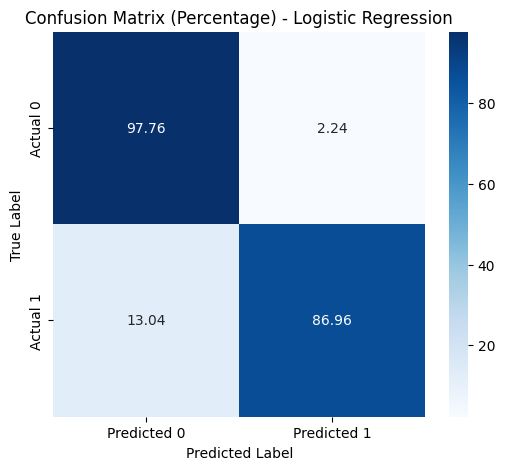

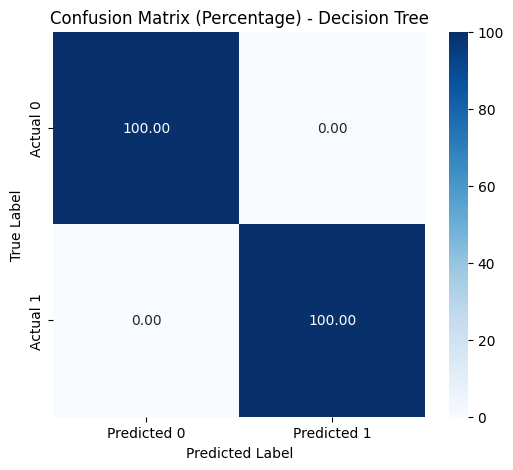

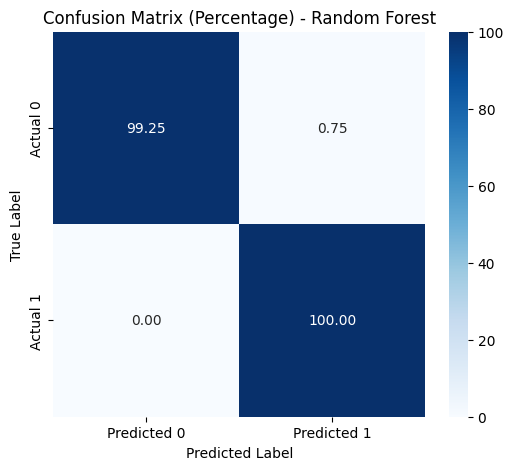

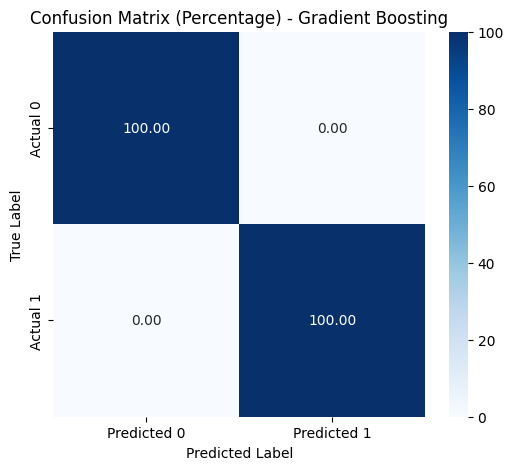

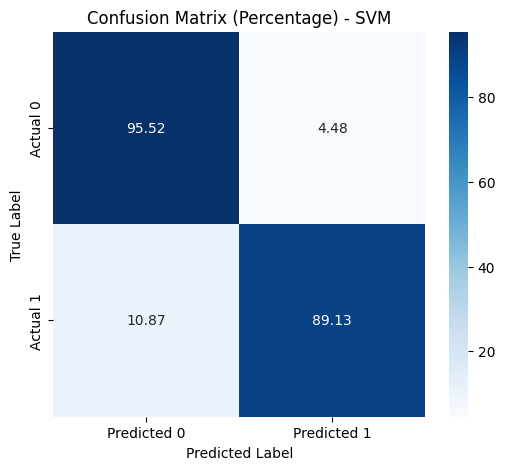

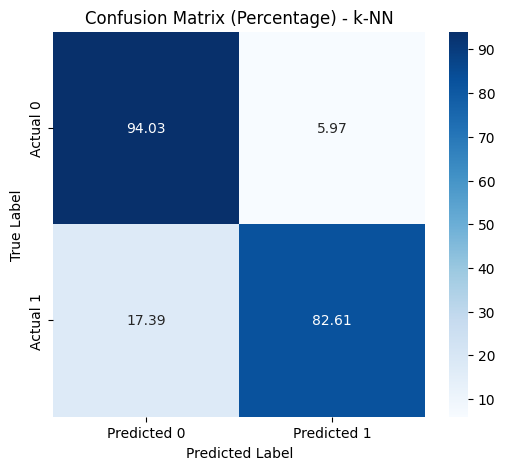

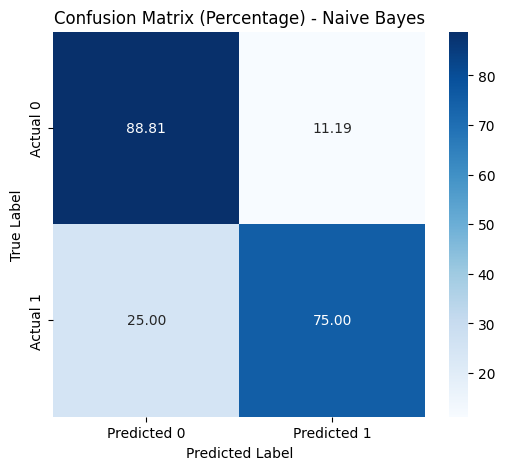

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix for each model
def plot_confusion_matrices(models, X_test, y_test):
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f"Confusion Matrix (Percentage) - {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

# Run the function after training models
plot_confusion_matrices(models, X_test, y_test)



The Decision Tree, Random Forest, and Gradient Boosting models exhibit a high risk of overfitting, as evidenced by their perfect accuracy (1.0000) and ROC-AUC scores (1.0000). This suggests that they have memorized the training data rather than learned generalizable patterns, which may lead to poor performance on unseen data.

In contrast, Logistic Regression and SVM demonstrate the most balanced performance, with high accuracy (about 93%) and strong ROC-AUC scores (≥96%), indicating good generalization while avoiding overfitting. K-NN and Naive Bayes perform comparatively worse, with lower accuracy (~89% and ~83%) and weaker recall, making them less reliable for precise predictions.

Given these results, Logistic Regression and SVM are the most suitable models, balancing accuracy, interpretability, and generalization.

However, we will fine-tune the **Logistic Regression**, **SVM**, **K-NN**, and **Naive Bayes** models for better performance.

## Fine-tuning Models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grids for tuning
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
        "solver": ["liblinear", "lbfgs"],  # Optimization algorithm
        "penalty": ["l1", "l2", "elasticnet", "none"],  # Regularization type
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],  # Regularization
        "kernel": ["linear", "rbf", "poly"],  # Kernel type
        "gamma": ["scale", "auto"],  # Kernel coefficient
    },
    "K-NN": {
        "n_neighbors": [3, 5, 7, 9, 11],  # Number of neighbors
        "weights": ["uniform", "distance"],  # Weighting method
        "metric": ["euclidean", "haversine", "manhattan", "minkowski"],  # Distance metrics
    },
    "Naive Bayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],  # Smoothing parameter
    },
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SVM": SVC(probability=True),
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

# Perform GridSearchCV for each model
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring="accuracy", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best model and parameters
    best_models[name] = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}\n")

# Evaluate on test data
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy for {name}: {accuracy:.4f}")


Tuning Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
125 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

Best Parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9956

Tuning SVM...
Best Parameters for SVM: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.9900

Tuning K-NN...
Best Parameters for K-NN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9291

Tuning Naive Bayes...
Best Parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best Cross-Validation Accuracy: 0.8793

Final Test Accuracy for Logistic Regression: 0.9867
Final Test Accuracy for SVM: 0.9823
Final Test Accuracy for K-NN: 0.9248
Final Test Accuracy for Naive Bayes: 0.8319


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 239, in fit
    return self._fit(X,

After fine-tuning, Logistic Regression achieved the highest accuracy (98.67%), followed closely by SVM (98.23%). These models demonstrate strong generalization, making them the most reliable choices for prediction.

K-NN improved but remained lower at 92.48%, suggesting it may not be as effective for this dataset. Naive Bayes, despite being computationally efficient, had the lowest accuracy (83.19%), likely due to its assumption of feature independence, which may not hold for this dataset.

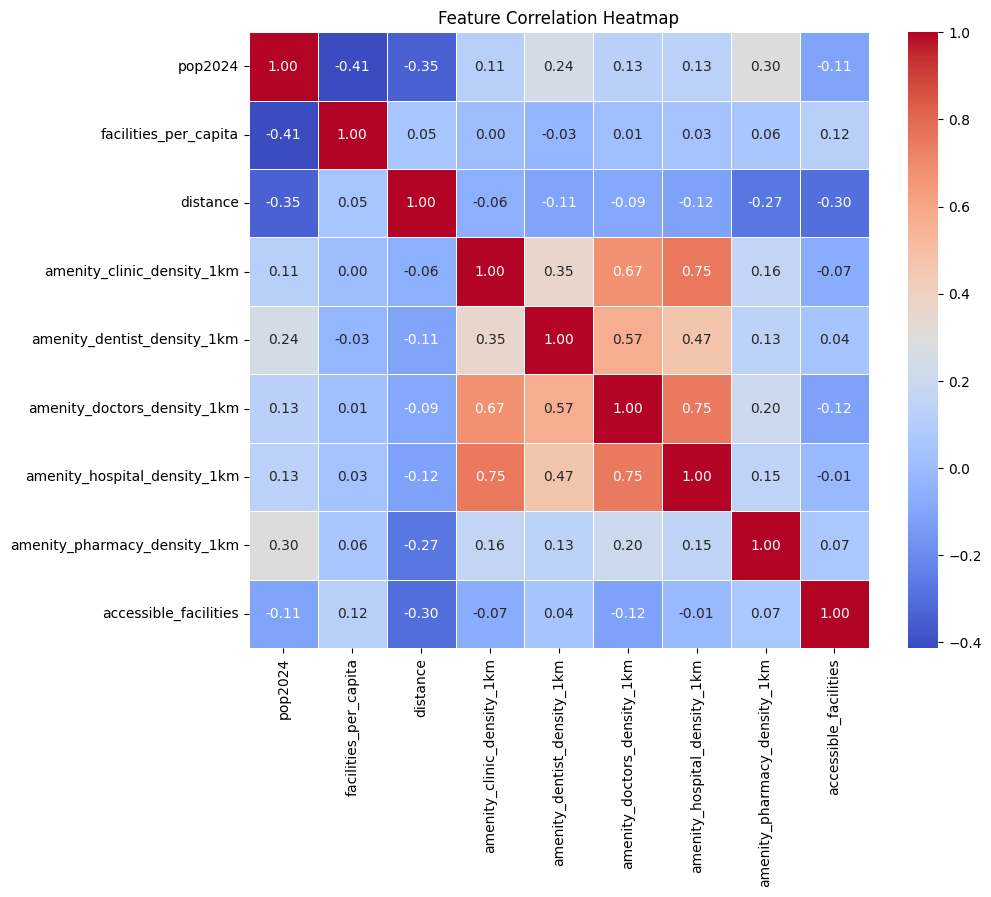

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the features used in modeling
features_to_plot = [
    "pop2024",
    "facilities_per_capita",
    "distance",
    "amenity_clinic_density_1km",
    "amenity_dentist_density_1km",
    "amenity_doctors_density_1km",
    "amenity_hospital_density_1km",
    "amenity_pharmacy_density_1km",
    "accessible_facilities"  # Including target variable for reference
]

# Compute correlation matrix
correlation_matrix = merged_copy[features_to_plot].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Import required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Example: load or create your data (replace this with your own data)
# For demonstration, let's assume X and y are already defined.
# X, y = ...

# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your models in a dictionary for convenience
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Loop through the models, fit them, predict, and compute metrics
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    # When working with multiclass classification, you can use 'weighted' average.
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print(f"Model: {model_name}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Model: Logistic Regression
  Accuracy:  0.9336
  Precision: 0.9355
  Recall:    0.9336
  F1 Score:  0.9330
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       134
           1       0.96      0.87      0.91        92

    accuracy                           0.93       226
   macro avg       0.94      0.92      0.93       226
weighted avg       0.94      0.93      0.93       226

--------------------------------------------------
Model: SVM
  Accuracy:  0.9292
  Precision: 0.9293
  Recall:    0.9292
  F1 Score:  0.9289
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       134
           1       0.93      0.89      0.91        92

    accuracy                           0.93       226
   macro avg       0.93      0.92      0.93       226
weighted avg       0.93      0.93      0.93       226

--------------------------------------------------
